# 성주님 code 실행 결과

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

# --- 사전 설정 ---
# 1. 한글 폰트 설정 (Mac: AppleGothic, Windows: Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [3]:
# 2. 파일 불러오기 (실행하는 위치에 CSV 파일이 함께 있어야 합니다)
try:
    file_name = '19+ 웹툰 서비스에 대한 브랜드 인식 변화 조사 설문(응답).xlsx'
    df = pd.read_excel(file_name)
    print("파일을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print(f"'{file_name}'을 찾을 수 없습니다. 코드와 같은 폴더에 파일이 있는지 확인해주세요.")
    df = None # 파일이 없으면 이후 코드 실행 방지

파일을 성공적으로 불러왔습니다.


In [ ]:
# 3. 분석에 사용할 컬럼명 정의
if df is not None:
    age_col = '1. 연령대가 어떻게 되시나요?'
    child_col = '5. 현재 미성년 자녀가 있으신가요?'
    image_col = "6. '네이버' 하면 가장 먼저 떠오르는 이미지는 어떤 것들이 있나요? (최대 3개까지 선택하실 수 있어요)"
    freq_col = '14. 네이버 웹툰 서비스를 얼마나 자주 사용하고 계신가요?'
    impact_col = '25. 네이버 웹툰이 성인 독자층까지 고려한 다양한 작품을 제공하는 것이 네이버 웹툰 브랜드 이미지에 부정적인 영향을 끼쳤다고 생각하시나요?'
    # concern_col = '귀하의 자녀(또는 주변 미성년자)가 네이버 웹툰 이용 시, 의도치 않게 연령에 맞지 않는 콘텐츠에 노출될 가능성에 대해 얼마나 우려하십니까?' # 예외 사유 - 문항 없음
    # loyalty_col = '앞으로도 네이버 웹툰 서비스를 계속 이용할 의향이 있으십니까?' # 예외 사유 - 답변 없음
    reason_col = '18. 웹툰을 보는 주된 이유는 무엇인가요? (3개 이내로 골라주세요)'


In [17]:
# --- 그래프 생성 함수들 ---
# 그래프가 여러 개이므로 함수로 묶어 관리합니다.
def plot_age_distribution(df):
    """차트 1: 응답자 연령대 분포"""
    plt.figure(figsize=(10, 6))
    age_order = ['10대', '20대', '30대', '40대', '50대 이상']
    sns.countplot(y=df[age_col], order=age_order, palette='viridis')
    plt.title('응답자 연령대 분포', fontsize=16)
    plt.xlabel('응답자 수 (명)', fontsize=12)
    plt.ylabel('연령대', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [18]:
def plot_brand_image(df):
    """차트 2: 네이버 웹툰 연상 이미지"""
    image_responses = df[image_col].dropna().apply(lambda x: x.split(', '))
    image_counts = pd.Series([item for sublist in image_responses for item in sublist]).value_counts()
    plt.figure(figsize=(12, 8))
    image_counts.sort_values().plot(kind='barh', color=sns.color_palette('mako', len(image_counts)))
    plt.title('네이버 웹툰 연상 이미지 (복수 응답)', fontsize=16)
    plt.xlabel('응답 수', fontsize=12)
    plt.ylabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [19]:
def plot_impact_by_frequency(df):
    """차트 3: 이용 빈도에 따른 브랜드 이미지 영향 인식"""
    df_copy = df.copy()
    freq_order = ['거의 매일', '주 4~5회', '주 2~3회', '주 1회', '월 2~3회', '월 1회 이하']
    impact_map = {1: '매우 부정적 영향', 2: '다소 부정적 영향', 3: '영향 없음(무관함)', 4: '다소 긍정적 영향', 5: '매우 긍정적 영향'}
    df_copy[impact_col] = pd.to_numeric(df_copy[impact_col], errors='coerce').map(impact_map)

    crosstab_df = pd.crosstab(df_copy[freq_col], df_copy[impact_col])
    crosstab_df = crosstab_df.reindex(index=freq_order, columns=impact_map.values()).fillna(0)
    crosstab_norm = crosstab_df.div(crosstab_df.sum(axis=1), axis=0) * 100

    crosstab_norm.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='coolwarm_r', width=0.8)
    plt.title('이용 빈도에 따른 19+ 콘텐츠의 브랜드 이미지 영향 인식', fontsize=16)
    plt.xlabel('응답 비율 (%)', fontsize=12)
    plt.ylabel('이용 빈도', fontsize=12)
    plt.legend(title='브랜드 이미지 영향', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [20]:
# def plot_parent_comparison(df):
#     """차트 4: 40대 부모 그룹과 전체 응답자 인식 비교"""
#     df_copy = df.copy()
#     df_copy[concern_col] = pd.to_numeric(df_copy[concern_col], errors='coerce')
#     df_copy[loyalty_col] = pd.to_numeric(df_copy[loyalty_col], errors='coerce')

#     parents_40s = df_copy[(df_copy[age_col] == '40대') & (df_copy[child_col] == '예')]
    
#     concern_avg_total = df_copy[concern_col].mean()
#     loyalty_avg_total = df_copy[loyalty_col].mean()
#     concern_avg_parents = parents_40s[concern_col].mean()
#     loyalty_avg_parents = parents_40s[loyalty_col].mean()

#     comparison_data = pd.DataFrame({
#         '전체 평균': [concern_avg_total, loyalty_avg_total],
#         '40대 부모 그룹 평균': [concern_avg_parents, loyalty_avg_parents]
#     }, index=['자녀 노출 우려도', '서비스 지속 이용 의향'])

#     comparison_data.plot(kind='bar', figsize=(10, 7), rot=0, colormap='winter')
#     plt.title('40대 부모 그룹과 전체 응답자 인식 비교', fontsize=16)
#     plt.ylabel('평균 점수 (5점 만점)', fontsize=12)
#     plt.xlabel('')
#     plt.xticks(fontsize=12)
#     plt.legend(title='응답자 그룹')
#     plt.grid(axis='y', linestyle='--', alpha=0.6)
#     for i, v in enumerate(comparison_data['전체 평균']):
#         if pd.notna(v): plt.text(i - 0.2, v + 0.05, f'{v:.2f}', color='blue', fontweight='bold')
#     for i, v in enumerate(comparison_data['40대 부모 그룹 평균']):
#         if pd.notna(v): plt.text(i + 0.05, v + 0.05, f'{v:.2f}', color='green', fontweight='bold')
#     plt.show()


In [21]:
def plot_usage_reason(df):
    """차트 5: 성인 대상 작품 이용 이유"""
    reason_responses = df[reason_col].dropna().apply(lambda x: x.split(', '))
    reason_counts = pd.Series([item for sublist in reason_responses for item in sublist]).value_counts()
    plt.figure(figsize=(12, 8))
    reason_counts.sort_values().plot(kind='barh', color=sns.color_palette('rocket', len(reason_counts)))
    plt.title('성인 대상 작품 이용 이유 (복수 응답)', fontsize=16)
    plt.xlabel('응답 수', fontsize=12)
    plt.ylabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


--- 차트 1: 응답자 연령대 분포 ---


C:\Users\HSJ\AppData\Local\Temp\ipykernel_44240\3877078876.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[age_col], order=age_order, palette='viridis')


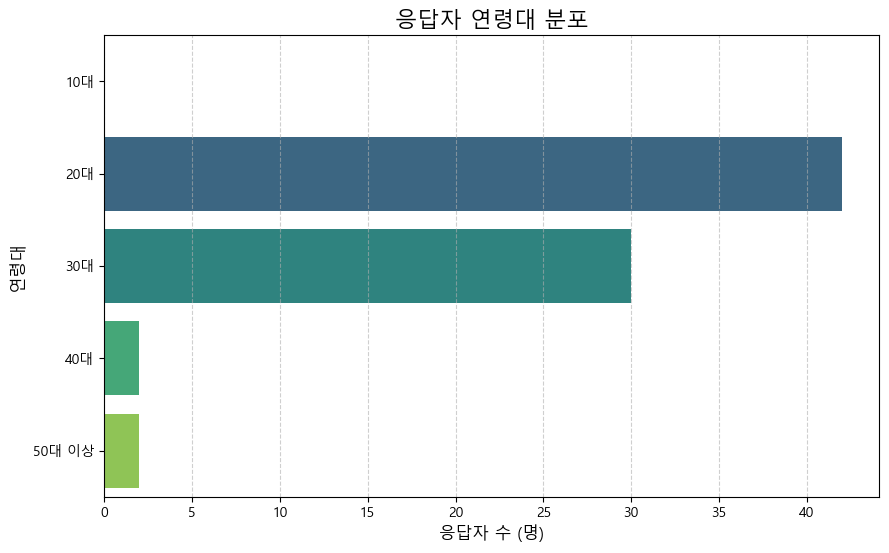


--- 차트 2: 네이버 웹툰 연상 이미지 ---


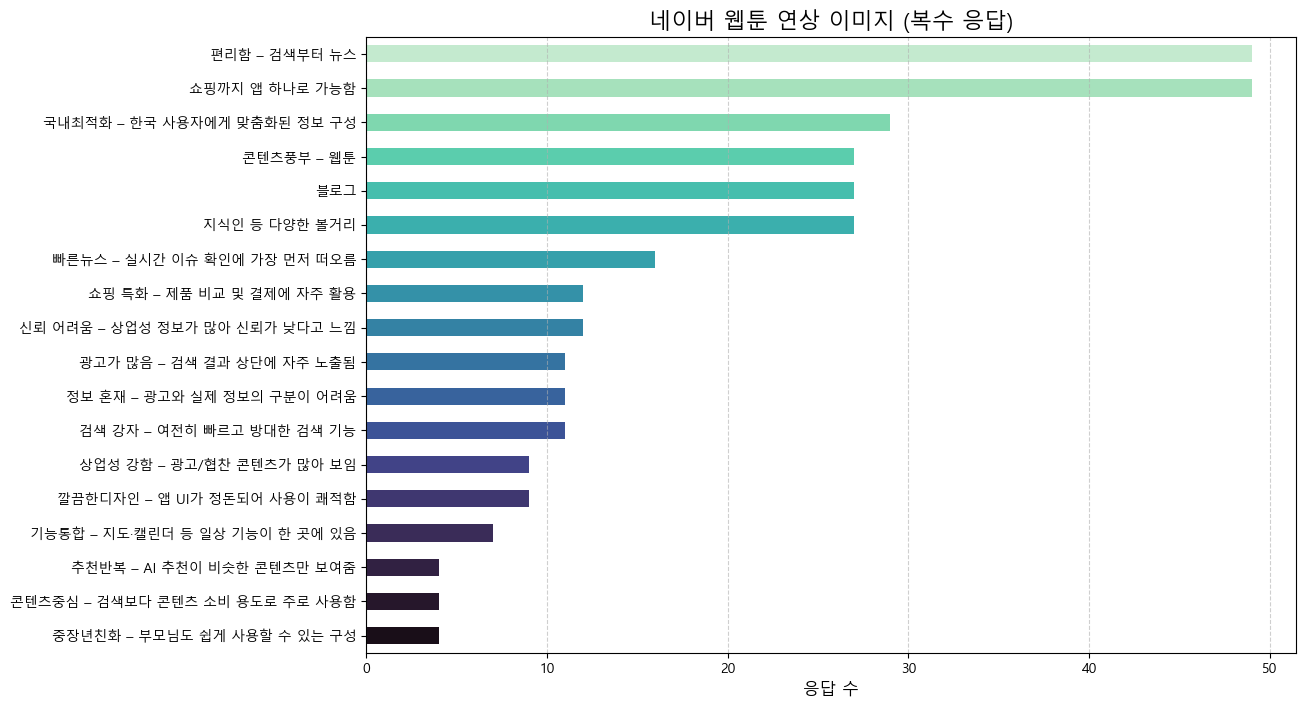


--- 차트 3: 이용 빈도에 따른 브랜드 이미지 영향 인식 ---


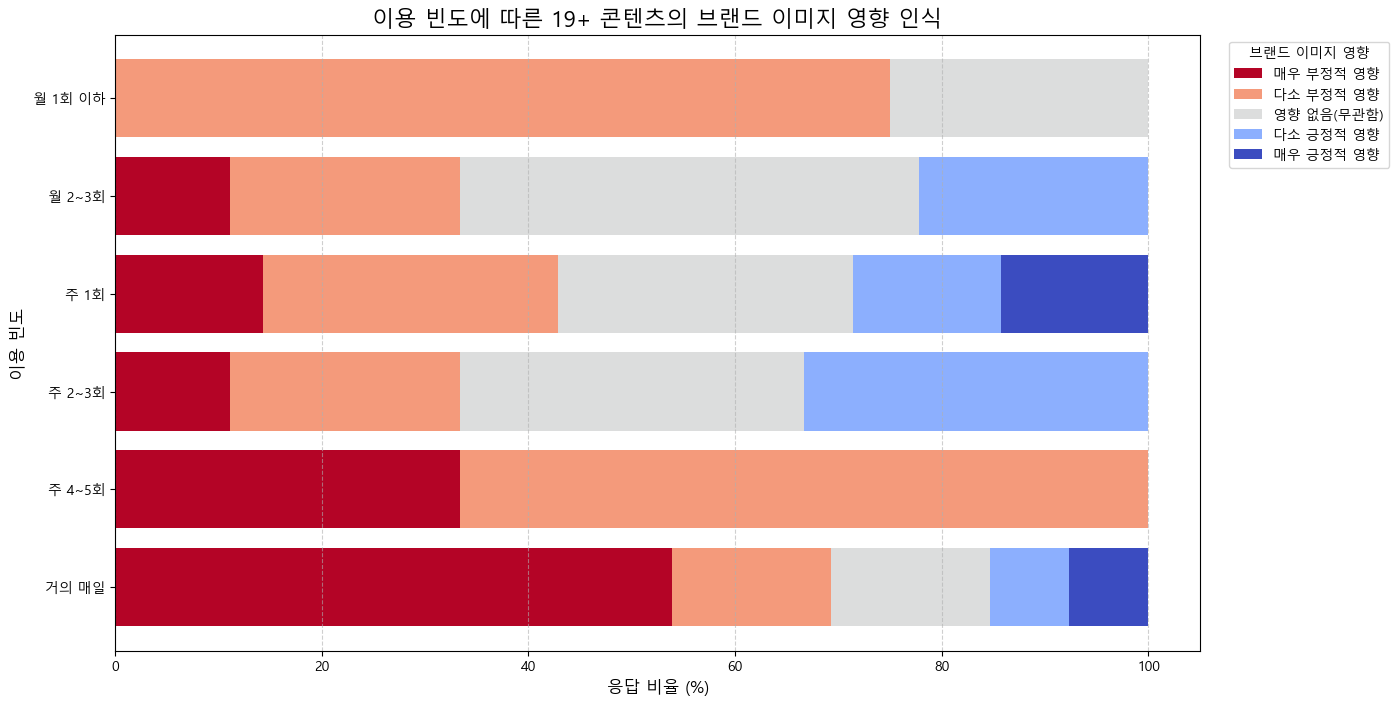


--- 차트 5: 성인 대상 작품 이용 이유 ---


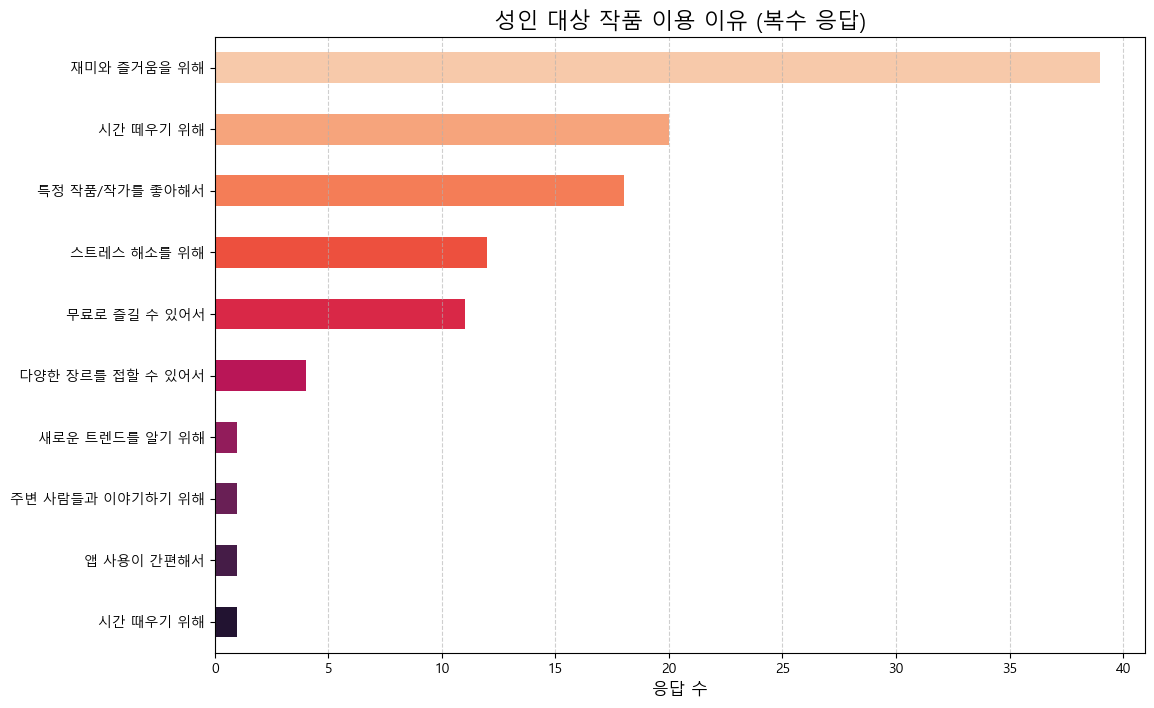

In [22]:
# --- 코드 실행 ---
if df is not None:
    print("--- 차트 1: 응답자 연령대 분포 ---")
    plot_age_distribution(df)
    print("\n--- 차트 2: 네이버 웹툰 연상 이미지 ---")
    plot_brand_image(df)
    print("\n--- 차트 3: 이용 빈도에 따른 브랜드 이미지 영향 인식 ---")
    plot_impact_by_frequency(df)
    #print("\n--- 차트 4: 40대 부모 그룹과 전체 응답자 인식 비교 ---")
    #plot_parent_comparison(df)
    print("\n--- 차트 5: 성인 대상 작품 이용 이유 ---")
    plot_usage_reason(df)

In [23]:
# 실제 컬럼명 확인
print(df.columns.tolist())

['타임스탬프', "개인정보 수집 및 이용 동의 안내\n안녕하세요. 본 설문에 참여해주셔서 진심으로 감사드립니다. 설문 시작에 앞서, 응답자님의 소중한 개인정보 수집 및 이용에 관한 동의를 받고자 합니다. 아래 내용을 자세히 읽어보시고 동의 여부를 결정해주시기 바랍니다.\n1. 개인정보 수집 및 이용 목적 본 설문조사는 '네이버 웹툰의 콘텐츠와 네이버 브랜드 이미지'에 대한 사용자 여러분의 인식과 경험을 파악하여, 더 나은 서비스 개선 및 관련 연구를 위한 기초 자료로 활용하는 것을 목적으로 합니다.\n2. 수집하는 개인정보 항목\n응답자 정보: 연령대, 성별, 현재 직업, 결혼 여부, 미성년 자녀 유무 \n설문 응답 내용: 네이버 브랜드 및 서비스에 대한 인식, 웹툰 이용 행태, 네이버 웹툰 사용 경험, 콘텐츠에 대한 인식 및 경험, 관련 의견 등 \n3. 개인정보의 보유 및 이용 기간 수집된 개인정보는 연구 목적 달성 시까지 보유하며, 연구 종료 후에는 통계적 분석 자료를 제외한 개인 식별이 가능한 정보는 안전하게 파기됩니다. 모든 응답은 익명으로 처리되어 개인을 특정할 수 있는 형태로 공개되거나 제3자에게 제공되지 않습니다.\n4. 동의를 거부할 권리 및 동의 거부에 따른 불이익 귀하는 위와 같은 개인정보 수집 및 이용에 동의하지 않으실 권리가 있습니다. 동의를 거부하시더라도 설문 참여 외의 다른 불이익은 없습니다. 다만, 동의하지 않으실 경우 설문조사 참여가 제한될 수 있습니다.\n5. 익명성 보장 본 설문은 익명으로 진행되며, 응답해주신 내용은 개인을 식별할 수 없는 통계 자료로만 활용될 것을 약속드립니다.\n위의 모든 내용을 숙지하였으며, 개인정보 수집 및 이용에 동의하십니까?", '1. 연령대가 어떻게 되시나요?', '2. 성별을 알려주실 수 있나요?', '3. 현재 어떤 일을 하고 계신가요?', '4. 결혼 여부는 어떻게 되시나요?', '5. 현재 미성년 자녀가 있으신가요?', "6. '네이버' 하면 가장 먼저 떠오르는 이미지는 어떤 것들이 있나

# 데이터 전처리 진행

| 문항 번호 | 질문 내용                                                                                                         | 추천 컬럼명                                        | 인코딩 방식                 |
| ----- | ------------------------------------------------------------------------------------------------------------- | --------------------------------------------- | ---------------------- |
| 1     | 연령대가 어떻게 되시나요?                                                                                                | `age_group`                                   | 레이블 인코딩 또는 원-핫 인코딩     |
| 2     | 성별을 알려주실 수 있나요?                                                                                               | `gender`                                      | 레이블 인코딩 또는 원-핫 인코딩     |
| 3     | 현재 어떤 일을 하고 계신가요?                                                                                             | `occupation`                                  | 원-핫 인코딩                |
| 4     | 결혼 여부는 어떻게 되시나요?                                                                                              | `marital_status`                              | 레이블 인코딩                |
| 5     | 현재 미성년 자녀가 있으신가요?                                                                                             | `has_minor_children`                          | 이진 인코딩 (예: 1=예, 0=아니오) |
| 6     | '네이버' 하면 가장 먼저 떠오르는 이미지는 어떤 것들이 있나요? (최대 3개까지 선택하실 수 있어요)                                                     | `naver_image_association`                     | 다중 선택 원-핫 인코딩          |
| 7     | 전반적으로 네이버 서비스에 얼마나 만족하고 계신가요?                                                                                 | `naver_service_satisfaction`                  | 순서형 인코딩 (예: 1\~5점 척도)  |
| 8     | 평소 자주 사용하는 네이버 서비스는 무엇인가요? (최대 3개까지 선택하실 수 있어요)                                                               | `frequent_naver_services`                     | 다중 선택 원-핫 인코딩          |
| 9     | 최근 1년 안에 웹툰을 본 적이 있으신가요?                                                                                      | `webtoon_usage_last_year`                     | 이진 인코딩                 |
| 10    | 사용 중인 웹툰 플랫폼이 있다면 모두 선택해주실 수 있나요?                                                                             | `webtoon_platforms_used`                      | 다중 선택 원-핫 인코딩          |
| 11    | 네이버 웹툰을 사용하지 않으셨다면, 어떤 이유가 있으신가요?                                                                             | `reason_not_using_naver_webtoon`              | 텍스트 또는 레이블 인코딩         |
| 11-1  | 추후에 네이버 웹툰을 이용해볼 생각이 있으신가요?                                                                                   | `intent_to_use_naver_webtoon`                 | 이진 인코딩                 |
| 12    | 네이버 웹툰을 얼마나 오랫동안 사용해오셨나요?                                                                                     | `naver_webtoon_usage_duration`                | 레이블 인코딩                |
| 13    | 네이버 웹툰 하면 떠오르는 이미지를 3개 이내로 골라주실 수 있을까요? (최대 3개까지 선택하실 수 있어요)                                                  | `naver_webtoon_image_association`             | 다중 선택 원-핫 인코딩          |
| 14    | 네이버 웹툰 서비스를 얼마나 자주 사용하고 계신가요?                                                                                 | `naver_webtoon_usage_frequency`               | 레이블 인코딩                |
| 15    | 네이버 웹툰에서 가장 선호하는 웹툰 장르는 어떤 것 인가요?                                                                             | `preferred_webtoon_genre`                     | 원-핫 인코딩                |
| 16    | 네이버 웹툰 콘텐츠 이용을 위해 유료 결제(예: 쿠키 충전, 유료 회차 구매 등)를 한 경험이 있으십니까?                                                   | `has_paid_for_webtoon`                        | 이진 인코딩                 |
| 17    | (결제 경험이 있으시다면) 지난 1년 동안 월평균 결제 금액은 어느 정도 되시나요?                                                                | `average_monthly_payment`                     | 레이블 인코딩딩                    |
| 18    | 웹툰을 보는 주된 이유는 무엇인가요? (3개 이내로 골라주세요)                                                                           | `reasons_for_reading_webtoons`                | 다중 선택 원-핫 인코딩          |
| 19    | 성인 연령 확인 후 열람 가능한 콘텐츠가 있다는 것을 알고 계셨나요?                                                                        | `aware_of_age_restricted_content`             | 이진 인코딩                 |
| 20    | 일반적으로 웹툰 플랫폼이 성인 연령 제한 작품을 제공하는 것에 대해 어떻게 생각하시나요?                                                             | `opinion_on_age_restricted_content`           | 레이블 인코딩                |
| 21    | 네이버 웹툰에서 성인 연령 제한 작품을 이용해본 경험이 있으신가요?                                                                         | `used_age_restricted_content`                 | 이진 인코딩                 |
| 22    | 성인 연령 제한 작품을 이용하신 주된 이유는 무엇인가요?                                                                               | `reason_for_using_age_restricted_content`     | 텍스트 또는 레이블 인코딩         |
| 23    | 이용하지 않으셨다면, 주된 이유는 무엇인가요?                                                                                     | `reason_for_not_using_age_restricted_content` | 텍스트 또는 레이블 인코딩         |
| 24    | 네이버 웹툰이 성인 연령 제한 작품을 포함하여 다양한 연령층을 고려한 콘텐츠를 제공하는 것에 대해 어떻게 생각하시나요?                                            | `opinion_on_content_for_various_ages`         | 순서형 인코딩                |
| 25    | 네이버 웹툰이 성인 독자층까지 고려한 다양한 작품을 제공하는 것이 네이버 웹툰 브랜드 이미지에 부정적인 영향을 끼쳤다고 생각하시나요?                                    | `impact_on_brand_image`                       | 순서형 인코딩                |
| 25-1  | (주관식) 왜 그렇게 느끼셨는지 자유롭게 작성해주실 수 있을까요?                                                                          | `reason_for_brand_image_opinion`              | 텍스트                    |
| 26    | 이러한 콘텐츠 구성(예: 다양한 연령층 대상 작품 제공 등)이 '네이버'라는 기업 전체의 브랜드 이미지에 부정적 영향을 준다고 생각하시나요?                                | `impact_on_company_brand_image`               | 순서형 인코딩                |
| 26-1  | (주관식) 가장 큰 영향을 주었다고 느끼신 측면이나 요인은 무엇인가요? 간단히 말씀해 주세요.                                                          | `reason_for_company_brand_image_opinion`      | 텍스트                    |
| 27    | 타 웹툰 플랫폼(예: 카카오, 레진코믹스, 탑툰 등)과 비교했을 때, 네이버 웹툰의 성인 연령 제한 작품 수위는 어떤 편이라고 생각하시나요?                                | `comparison_of_age_restricted_content_level`  | 순서형 인코딩                |
| 28    | 네이버 웹툰에서 성인 연령 확인 후 이용 가능한 작품들을 접하시면서 불편하거나 개선되었으면 하는 점이 있었나요? (네이버 웹툰 이용자 대상)                                | `issues_with_age_restricted_content`          | 이진 인코딩                 |
| 29    | (주관식) 구체적으로 어떤 점이 불편했는지 알려주실 수 있나요?                                                                           | `specific_issues_with_age_restricted_content` | 텍스트                    |
| 30    | 현재 네이버 웹툰에서 다양한 연령대의 작품들을 구분하고, 성인 확인이 필요한 작품들에 대한 접근을 관리하는 기능(예: 성인인증, 검색 노출 방식 등)에 대해 얼마나 만족하시나요?           | `satisfaction_with_content_management`        | 순서형 인코딩                |
| 31    | 네이버 웹툰에서 성인 독자를 위한 작품들을 더 쉽게 발견하거나 관련 추천이 늘어난다면 (성인 연령 제한 작품이 더 눈에 띄게 노출된다면), 해당 작품들을 이전보다 더 자주 보게 될 것 같으신가요? | `likelihood_of_increased_viewing`             | 순서형 인코딩                |
| 32    | 네이버 웹툰을 앞으로도 계속 사용하실 의향이 있으신가요? (네이버 웹툰 이용자 대상)                                                               | `intention_to_continue_using_naver_webtoon`   | 순서형 인코딩                |


In [92]:
# 1. 파일 불러오기 및 컬럼명 정리
file_name = '19+ 웹툰 서비스에 대한 브랜드 인식 변화 조사 설문(응답)_변경.xlsx'
df = pd.read_excel(file_name)
df.columns = df.columns.str.strip()


# 2. 타임스탬프 컬럼을 고유번호로 대체 & 이용자 동의 컬럼 내용 삭제

# 타임스탬프 컬럼명 확인 후 아래에 입력 (예시: 'Timestamp')
timestamp_col = '타임스탬프'  # 실제 컬럼명으로 수정
if timestamp_col in df.columns:
    df = df.drop(columns=[timestamp_col])
    df.insert(0, 'no', range(1, len(df) + 1))  # 1번부터 시작하는 고유번호 부여

# 이용자 동의 컬럼명 삭제 (예시: '이용자 동의')
df = df.drop(df.columns[1], axis=1)



# 3. 컬럼명 한글→영문 치환 (실제 컬럼명에 맞게 수정)
rename_dict = {
    '1. 연령대가 어떻게 되시나요?': 'age_group',
    '2. 성별을 알려주실 수 있나요?': 'gender',
    '3. 현재 어떤 일을 하고 계신가요?': 'occupation',
    '4. 결혼 여부는 어떻게 되시나요?': 'marital_status',
    '5. 현재 미성년 자녀가 있으신가요?': 'has_minor_children',
    "6. '네이버' 하면 가장 먼저 떠오르는 이미지는 어떤 것들이 있나요? (최대 3개까지 선택하실 수 있어요)": 'naver_image_association',
    '7. 전반적으로 네이버 서비스에 얼마나 만족하고 계신가요?': 'naver_service_satisfaction',
    '8. 평소 자주 사용하는 네이버 서비스는 무엇인가요? (최대 3개까지 선택하실 수 있어요)': 'frequent_naver_services',
    '9. 최근 1년 안에 웹툰을 본 적이 있으신가요?': 'webtoon_usage_last_year',
    '10. 사용 중인 웹툰 플랫폼이 있다면 모두 선택해주실 수 있나요?': 'webtoon_platforms_used',
    '11. 네이버 웹툰을 사용하지 않으셨다면, 어떤 이유가 있으신가요?': 'reason_not_using_naver_webtoon',
    '11-1. 추후에 네이버 웹툰을 이용해볼 생각이 있으신가요?': 'intent_to_use_naver_webtoon',
    '12. 네이버 웹툰을 얼마나 오랫동안 사용해오셨나요?': 'naver_webtoon_usage_duration',
    '13. 네이버 웹툰 하면 떠오르는 이미지를 3개 이내로 골라주실 수 있을까요? (최대 3개까지 선택하실 수 있어요)': 'naver_webtoon_image_association',
    '14. 네이버 웹툰 서비스를 얼마나 자주 사용하고 계신가요?': 'naver_webtoon_usage_frequency',
    '15. 네이버 웹툰에서 가장 선호하는 웹툰 장르는 어떤 것 인가요?': 'preferred_webtoon_genre',
    '16. 네이버 웹툰 콘텐츠 이용을 위해 유료 결제(예: 쿠키 충전, 유료 회차 구매 등)를 한 경험이 있으십니까?': 'has_paid_for_webtoon',
    '17. (결제 경험이 있으시다면) 지난 1년 동안 월평균 결제 금액은 어느 정도 되시나요?': 'average_monthly_payment',
    '18. 웹툰을 보는 주된 이유는 무엇인가요? (3개 이내로 골라주세요)': 'reasons_for_reading_webtoons',
    '19. 성인 연령 확인 후 열람 가능한 콘텐츠가 있다는 것을 알고 계셨나요?': 'aware_of_age_restricted_content',
    '20. 일반적으로 웹툰 플랫폼이 성인 연령 제한 작품을 제공하는 것에 대해 어떻게 생각하시나요?': 'opinion_on_age_restricted_content',
    '21. 네이버 웹툰에서 성인 연령 제한 작품을 이용해본 경험이 있으신가요?': 'used_age_restricted_content',
    '22. 성인 연령 제한 작품을 이용하신 주된 이유는 무엇인가요?': 'reason_for_using_age_restricted_content',
    '23. 이용하지 않으셨다면, 주된 이유는 무엇인가요?': 'reason_for_not_using_age_restricted_content',
    '24. 네이버 웹툰이 성인 연령 제한 작품을 포함하여 다양한 연령층을 고려한 콘텐츠를 제공하는 것에 대해 어떻게 생각하시나요?': 'opinion_on_content_for_various_ages',
    '25. 네이버 웹툰이 성인 독자층까지 고려한 다양한 작품을 제공하는 것이 네이버 웹툰 브랜드 이미지에 부정적인 영향을 끼쳤다고 생각하시나요?': 'impact_on_brand_image',
    '25-1. (주관식) 왜 그렇게 느끼셨는지 자유롭게 작성해주실 수 있을까요?': 'reason_for_brand_image_opinion',
    "26. 이러한 콘텐츠 구성(예: 다양한 연령층 대상 작품 제공 등)이 '네이버'라는 기업 전체의 브랜드 이미지에 부정적 영향을 준다고 생각하시나요?": 'impact_on_company_brand_image',
    '26-1. (주관식) 가장 큰 영향을 주었다고 느끼신 측면이나 요인은 무엇인가요? 간단히 말씀해 주세요.': 'reason_for_company_brand_image_opinion',
    '27. 타 웹툰 플랫폼(예: 카카오, 레진코믹스, 탑툰 등)과 비교했을 때, 네이버 웹툰의 성인 연령 제한 작품 수위는 어떤 편이라고 생각하시나요?': 'comparison_of_age_restricted_content_level',
    '28. 네이버 웹툰에서 성인 연령 확인 후 이용 가능한 작품들을 접하시면서 불편하거나 개선되었으면 하는 점이 있었나요? (네이버 웹툰 이용자 대상)': 'issues_with_age_restricted_content',
    '29. (주관식) 구체적으로 어떤 점이 불편했는지 알려주실 수 있나요?': 'specific_issues_with_age_restricted_content',
    '30. 현재 네이버 웹툰에서 다양한 연령대의 작품들을 구분하고, 성인 확인이 필요한 작품들에 대한 접근을 관리하는 기능(예: 성인인증, 검색 노출 방식 등)에 대해 얼마나 만족하시나요?': 'satisfaction_with_content_management',
    '31. 네이버 웹툰에서 성인 독자를 위한 작품들을 더 쉽게 발견하거나 관련 추천이 늘어난다면 (성인 연령 제한 작품이 더 눈에 띄게 노출된다면), 해당 작품들을 이전보다 더 자주 보게 될 것 같으신가요?': 'likelihood_of_increased_viewing',
    '32. 네이버 웹툰을 앞으로도 계속 사용하실 의향이 있으신가요? (네이버 웹툰 이용자 대상)': 'intention_to_continue_using_naver_webtoon'
}
df = df.rename(columns=rename_dict)

# 4. 이진 인코딩 (예/아니오 → 1/0)
binary_cols = [
    'has_minor_children', 'webtoon_usage_last_year', 'has_paid_for_webtoon',
    'aware_of_age_restricted_content', 'used_age_restricted_content',
    'intent_to_use_naver_webtoon', 'issues_with_age_restricted_content'
]
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'예': 1, '아니오': 0})

# 5. 다중 선택형(쉼표 구분) 컬럼 원-핫 인코딩
multi_cols = [
    'frequent_naver_services',
    'webtoon_platforms_used', 'naver_webtoon_image_association',
    'reasons_for_reading_webtoons'
]
for col in multi_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=', ')
        dummies = dummies.add_prefix(f'{col}_')
        df = pd.concat([df, dummies], axis=1)

# 5-1. 다중 선택형(쉼표/슬래시 등 구분) 컬럼 원-핫 인코딩 (naver_image_association만 지정 카테고리로 인코딩)


category_list = [
    "편리함 – 검색부터 뉴스, 쇼핑까지 앱 하나로 가능함",
    "광고가 많음 – 검색 결과 상단에 자주 노출됨",
    "빠른뉴스 – 실시간 이슈 확인에 가장 먼저 떠오름",
    "콘텐츠풍부 – 웹툰, 블로그, 지식인 등 다양한 볼거리",
    "신뢰 어려움 – 상업성 정보가 많아 신뢰가 낮다고 느낌",
    "쇼핑 특화 – 제품 비교 및 결제에 자주 활용",
    "추천반복 – AI 추천이 비슷한 콘텐츠만 보여줌",
    "중장년친화 – 부모님도 쉽게 사용할 수 있는 구성",
    "정보 혼재 – 광고와 실제 정보의 구분이 어려움",
    "기능통합 – 지도·캘린더 등 일상 기능이 한 곳에 있음",
    "상업성 강함 – 광고/협찬 콘텐츠가 많아 보임",
    "국내최적화 – 한국 사용자에게 맞춤화된 정보 구성",
    "깔끔한디자인 – 앱 UI가 정돈되어 사용이 쾌적함",
    "콘텐츠중심 – 검색보다 콘텐츠 소비 용도로 주로 사용함",
    "검색 강자 – 여전히 빠르고 방대한 검색 기능"
]

multi_cols = [
    'naver_image_association', 'frequent_naver_services',
    'webtoon_platforms_used', 'naver_webtoon_image_association',
    'reasons_for_reading_webtoons'
]
for col in multi_cols:
    if col in df.columns:
        if col == 'naver_image_association':
            # 다양한 구분자(쉼표, #, / 등)로 분리 후 정확히 카테고리와 일치하는 값만 인코딩
            def split_multi(x):
                return [i.strip() for i in re.split(r'#', str(x))]
            for cat in category_list:
                df[f'{col}_{cat}'] = df[col].apply(
                    lambda x: int(cat in split_multi(x))
                )
        else:
            dummies = df[col].str.get_dummies(sep=', ')
            dummies = dummies.add_prefix(f'{col}_')
            df = pd.concat([df, dummies], axis=1)

# 5-2. reason_not_using_naver_webtoon 인코딩 처리
# 주요 보기(카테고리)와 기타(자유응답) 구분
reason_categories = [
    "다른 플랫폼을 더 선호해서",
    "볼만한 작품이 없어서",
    "유료 콘텐츠 비용이 부담돼서",
    "서비스 이용이 불편해서",
    "19+ 콘텐츠가 있는 것이 싫어서",
    "네이버 웹툰에 대해 잘 몰라서"
]
# 기타로 인정할 키워드(정확히 일치)
etc_keywords = [
    "웹툰 내의 문제가 사회적 이슈로 떠올랐는데도 제대로 된 대처를 하지 않아서",
    "기다리는게 귀찮음",
    "다른 플랫폼을 더 선호해서",
    "서비스 이용이 불편해서"
    
]

def encode_reason(x):
    reasons = [i.strip() for i in str(x).split(',') if i.strip()]
    encoded = {}
    found = False
    for cat in reason_categories:
        encoded[f'reason_not_using_naver_webtoon_{cat}'] = int(cat in reasons)
        if cat in reasons:
            found = True
    # 기타(위 카테고리에 없는 응답 중, 지정된 기타 키워드만 포함)
    etc_found = any(r in etc_keywords for r in reasons)
    encoded['reason_not_using_naver_webtoon_기타'] = int(etc_found)
    return pd.Series(encoded)

if 'reason_not_using_naver_webtoon' in df.columns:
    reason_dummies = df['reason_not_using_naver_webtoon'].apply(encode_reason)
    df = pd.concat([df, reason_dummies], axis=1)


# 5-3. 다중 선택형(쉼표/슬래시 등 구분) 컬럼 원-핫 인코딩 (preferred_webtoon_genre)

genre_groups = [
    "로맨스 / 로맨스 판타지",
    "액션 / 판타지 / 무협",
    "스릴러 / 추리 / 미스터리",
    "드라마 / 감성",
    "학원 / 성장",
    "코미디 / 일상툰",
    "성인(19+)"
]

col = "preferred_webtoon_genre"
if col in df.columns:
    # 콤마(,)로 split해서 strip
    def split_multi(x):
        return [i.strip() for i in str(x).split(',') if i.strip()]
    for g in genre_groups:
        df[f'{col}_{g}'] = df[col].apply(lambda x: int(g in split_multi(x)))


# 6. 순서형 인코딩 (1~5점 척도 등)
ordinal_cols = [
    'naver_service_satisfaction',
    'opinion_on_content_for_various_ages', 'impact_on_brand_image',
    'impact_on_company_brand_image',
    'satisfaction_with_content_management',
    'intention_to_continue_using_naver_webtoon'
]

for col in ordinal_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


# 6-1 .12번 문항인인 naver_webtoon_usage_duration 레이블 인코딩
duration_label_map = {
    '6개월 미만': 1,
    '6개월 이상 ~ 1년 미만': 2,
    '1년 이상 ~ 3년 미만': 3,
    '3년 이상 ~ 5년 미만': 4,
    '5년 이상': 5
}
if 'naver_webtoon_usage_duration' in df.columns:
    df['naver_webtoon_usage_duration'] = df['naver_webtoon_usage_duration'].map(duration_label_map)


# 6-2. 14번 문항 naver_webtoon_usage_frequency 레이블 인코딩
frequency_label_map = {
    '거의 매일': 6,
    '주 4~5회': 5,
    '주 2~3회': 4,
    '주 1회': 3,
    '월 2~3회': 2,
    '월 1회 이하': 1
}
if 'naver_webtoon_usage_frequency' in df.columns:
    df['naver_webtoon_usage_frequency'] = df['naver_webtoon_usage_frequency'].map(frequency_label_map)


# 6-3. 17번 문항 월 평균 결제 금액 average_monthly_payment 레이블 인코딩
payment_label_map = {
    '1,000원 미만 (쿠키 ~10개)': 1,
    '1,000원 ~ 5,000원 미만 (쿠키 10개 ~ 50개)': 2,
    '5,000원 ~ 10,000원 미만 (쿠키 50개 ~ 100개)': 3,
    '10,000원 ~ 30,000원 미만 (쿠키 100개 ~ 300개)': 4,
    '30,000원 이상 (쿠키 300개 이상 ~)': 5
}
col = 'average_monthly_payment'
if col in df.columns:
    df[col] = df[col].map(payment_label_map)


# 6-4. 20번 문항: 일반적으로 웹툰 플랫폼이 성인 연령 제한 작품을 제공하는 것에 대해 어떻게 생각하시나요? 레이블 인코딩
# 원본 응답값 → 레이블 인코딩 매핑
opinion_label_map = {
    '전혀 필요하지 않다고 생각한다': 1,
    '별로 필요하지 않다고 생각한다': 2,
    '보통이다 (특별한 의견 없음)': 3,
    '어느 정도 필요하다고 생각한다': 4,
    '매우 필요하다고 생각한다': 5
}

col = 'opinion_on_age_restricted_content'
if col in df.columns:
    df[col] = df[col].map(opinion_label_map)
    print(df[col].value_counts().sort_index())
else:
    print("opinion_on_age_restricted_content 컬럼이 없습니다.")

# 6-5. 27번 문항: 타 웹툰 플랫폼과 비교한 네이버 웹툰의 성인 연령 제한 작품 수위 - 서열형 인코딩
# 원본 응답값 → 서열형 인코딩 매핑
comparison_label_map = {
    '훨씬 낮다': 1,
    '다소 낮다': 2,
    '비슷하다': 3,
    '다소 높다': 4,
    '훨씬 높다': 5,
    '잘 모르겠다/이용 안 해봐서 비교 불가': 0  # 비교 불가/모름은 0으로 처리
}

col = 'comparison_of_age_restricted_content_level'
if col in df.columns:
    df[col] = df[col].map(comparison_label_map)
    print(df[col].value_counts().sort_index())
else:
    print("comparison_of_age_restricted_content_level 컬럼이 없습니다.")

# 6-6. 31번 문항: likelihood_of_increased_viewing 순서형 인코딩

likelihood_label_map = {
    '전혀 그렇지 않다': 1,
    '별로 그렇지 않다': 2,
    '보통이다': 3,
    '어느 정도 그렇다': 4,
    '매우 그렇다': 5
}
col = 'likelihood_of_increased_viewing'
if col in df.columns:
    df[col] = df[col].map(likelihood_label_map)

# 8. 결측치 처리 (필요시)
df = df.fillna('')

# 9. 결과 확인
print(df.head())


opinion_on_age_restricted_content
1.0     1
2.0     2
3.0    22
4.0    21
5.0    18
Name: count, dtype: int64
comparison_of_age_restricted_content_level
0    27
1     6
2    20
3    17
4     5
5     1
Name: count, dtype: int64
   no age_group gender occupation marital_status  has_minor_children  \
0   1       20대     여성    현재 구직 중             미혼                   0   
1   2       20대     여성        회사원             기혼                   0   
2   3       20대     남성    현재 구직 중             미혼                   0   
3   4       20대     여성    현재 구직 중             미혼                   0   
4   5       20대     여성    현재 구직 중             미혼                   0   

                                                                      naver_image_association  \
0  편리함 – 검색부터 뉴스, 쇼핑까지 앱 하나로 가능함# 신뢰 어려움 – 상업성 정보가 많아 신뢰가 낮다고 느낌# 국내최적화 – 한국 사용자에게 맞춤화된 정보 구성   
1                                   편리함 – 검색부터 뉴스,쇼핑까지 앱 하나로 가능함# 국내최적화 – 한국 사용자에게 맞춤화된 정보 구성   
2     편리함 – 검색부터 뉴스, 쇼핑까지 앱 하나로 가능함# 빠른뉴스 – 실시간 이

In [7]:
df.describe()

,no,has_minor_children,naver_service_satisfaction,webtoon_usage_last_year,opinion_on_content_for_various_ages,impact_on_brand_image,impact_on_company_brand_image,satisfaction_with_content_management,frequent_naver_services_MYBOX,frequent_naver_services_검색,...,reasons_for_reading_webtoons_다양한 장르를 접할 수 있어서,reasons_for_reading_webtoons_무료로 즐길 수 있어서,reasons_for_reading_webtoons_새로운 트렌드를 알기 위해,reasons_for_reading_webtoons_스트레스 해소를 위해,reasons_for_reading_webtoons_시간 때우기 위해,reasons_for_reading_webtoons_시간 떼우기 위해,reasons_for_reading_webtoons_앱 사용이 간편해서,reasons_for_reading_webtoons_재미와 즐거움을 위해,reasons_for_reading_webtoons_주변 사람들과 이야기하기 위해,reasons_for_reading_webtoons_특정 작품/작가를 좋아해서
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,...,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,38.500000,0.105263,3.736842,0.763158,3.750000,2.526316,2.342105,3.342105,0.065789,0.631579,...,0.052632,0.144737,0.013158,0.157895,0.013158,0.263158,0.013158,0.513158,0.013158,0.236842
std,22.083176,0.308931,0.884962,0.427970,0.939858,1.171594,1.183809,0.792509,0.249561,0.485582,...,0.224781,0.354173,0.114708,0.367065,0.114708,0.443273,0.114708,0.503148,0.114708,0.427970
min,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.750000,0.000000,3.000000,1.000000,3.000000,2.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.500000,0.000000,4.000000,1.000000,4.000000,2.500000,2.000000,3.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,57.250000,0.000000,4.000000,1.000000,4.000000,3.000000,3.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,76.000000,1.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# 연령대 분포도 (Plotly, 순서 지정)
age_order = ['10대', '20대', '30대', '40대', '50대 이상']  # 원하는 순서로 지정
age_df = df['age_group'].value_counts().reindex(age_order).reset_index()
age_df.columns = ['age_group', 'count']
fig = px.pie(age_df,
             names='age_group', values='count',
             title='1. 연령대가 어떻게 되시나요?',
             labels={'age_group': '연령대', 'count': '응답자 수'})
fig.show()

In [5]:
# 2. 성별 분포 (Plotly 파이차트)
gender_df = df['gender'].value_counts().reset_index()
gender_df.columns = ['gender', 'count']
fig = px.pie(gender_df,
             names='gender', values='count',
             title='2. 성별을 알려주실 수 있나요?',
             labels={'gender': '성별', 'count': '응답자 수'})
fig.show()

In [6]:
# 3. 현재 어떤 일을 하고 계신가요? (Plotly 파이차트)
occupation_df = df['occupation'].value_counts().reset_index()
occupation_df.columns = ['occupation', 'count']
fig = px.pie(occupation_df,
             names='occupation', values='count',
             title='3. 현재 어떤 일을 하고 계신가요?',
             labels={'occupation': '직업', 'count': '응답자 수'})
fig.show()

In [7]:
# 4. 결혼 여부 (Plotly 파이차트)
marital_df = df['marital_status'].value_counts().reset_index()
marital_df.columns = ['marital_status', 'count']
fig = px.pie(marital_df,
             names='marital_status', values='count',
             title='4. 결혼 여부는 어떻게 되시나요?',
             labels={'marital_status': '결혼 여부', 'count': '응답자 수'})
fig.show()

In [8]:
# 5. 미성년 자녀 유무 (Plotly 파이차트, 레이블 예/아니오로 표시)
child_df = df['has_minor_children'].value_counts().reset_index()
child_df.columns = ['has_minor_children', 'count']
# 값이 1/0이므로 예/아니오로 변환
child_df['has_minor_children'] = child_df['has_minor_children'].map({1: '예', 0: '아니오'})
fig = px.pie(child_df,
             names='has_minor_children', values='count',
             title='5. 현재 미성년 자녀가 있으신가요?',
             labels={'has_minor_children': '미성년 자녀 유무', 'count': '응답자 수'})
fig.show()

In [21]:
# 6번 문항: '네이버' 하면 가장 먼저 떠오르는 이미지 시각화 - 이슈 공유(편리함 49인데 계속 48개씩 뜸)
image_col = 'naver_image_association'  # 전처리 후 영문 컬럼명 사용
category_list = [
    "편리함 – 검색부터 뉴스, 쇼핑까지 앱 하나로 가능함",
    "광고가 많음 – 검색 결과 상단에 자주 노출됨",
    "빠른뉴스 – 실시간 이슈 확인에 가장 먼저 떠오름",
    "콘텐츠풍부 – 웹툰, 블로그, 지식인 등 다양한 볼거리",
    "신뢰 어려움 – 상업성 정보가 많아 신뢰가 낮다고 느낌",
    "쇼핑 특화 – 제품 비교 및 결제에 자주 활용",
    "추천반복 – AI 추천이 비슷한 콘텐츠만 보여줌",
    "중장년친화 – 부모님도 쉽게 사용할 수 있는 구성",
    "정보 혼재 – 광고와 실제 정보의 구분이 어려움",
    "기능통합 – 지도·캘린더 등 일상 기능이 한 곳에 있음",
    "상업성 강함 – 광고/협찬 콘텐츠가 많아 보임",
    "국내최적화 – 한국 사용자에게 맞춤화된 정보 구성",
    "깔끔한디자인 – 앱 UI가 정돈되어 사용이 쾌적함",
    "콘텐츠중심 – 검색보다 콘텐츠 소비 용도로 주로 사용함",
    "검색 강자 – 여전히 빠르고 방대한 검색 기능"
]

if image_col in df.columns:
    def split_multi(x):
        # #로 split, strip, 빈 문자열 제거 (단일/복수 응답 모두 처리)
        return [i.strip() for i in str(x).split('#') if i.strip()]
    image_responses = df[image_col].dropna().apply(split_multi)
    mapped = []
    for sublist in image_responses:
        for item in sublist:
            if item in category_list:
                mapped.append(item)
    image_counts = pd.Series(mapped).value_counts().reindex(category_list, fill_value=0)
    respondent_count = df[image_col].dropna().shape[0]
    image_percents = (image_counts / respondent_count * 100).round(1)
    # 반대 순서로 표시
    image_counts = image_counts[::-1]
    image_percents = image_percents[::-1]
    bar_text = [f"{v} ({p}%)" for v, p in zip(image_counts.values, image_percents)]
    fig = px.bar(
        x=image_counts.values,
        y=image_counts.index,
        orientation='h',
        labels={'x': '응답 수', 'y': '이미지'},
        title="6. '네이버' 하면 가장 먼저 떠오르는 이미지는 어떤 것들이 있나요? (최대 3개까지 선택하실 수 있어요)"
    )
    fig.update_traces(
        text=bar_text,
        textposition='outside',
        marker_color='mediumseagreen'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()

In [9]:
# 7번 문항: 전반적으로 네이버 서비스에 얼마나 만족하고 계신가요?
# (1~5점 척도, 막대그래프)

if 'naver_service_satisfaction' in df.columns:
    sat_col = 'naver_service_satisfaction'
    # 값이 숫자형(1~5)인지 확인
    df[sat_col] = pd.to_numeric(df[sat_col], errors='coerce')
    sat_counts = df[sat_col].value_counts().sort_index()
    sat_percents = (sat_counts / sat_counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(sat_counts.values, sat_percents)]
    fig = px.bar(
        x=sat_counts.index.astype(str),
        y=sat_counts.values,
        text=bar_text,
        labels={'x': '만족도(점수)', 'y': '응답 수'},
        title='7. 전반적으로 네이버 서비스에 얼마나 만족하고 계신가요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='royalblue'
    )
    fig.update_layout(
        xaxis=dict(tickmode='linear', tick0=1, dtick=1, tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()

In [ ]:
# 8번 문항: 평소 자주 사용하는 네이버 서비스 (최대 3개까지 선택, 반대 순서) #시리즈온, 지식IN, 이용 서비스 없음 값은 모두 0이여서 제외되었습니다.
service_col = 'frequent_naver_services'

if service_col in df.columns:
    def split_multi(x):
        return [i.strip() for i in str(x).split(',') if i.strip()]
    service_responses = df[service_col].dropna().apply(split_multi)
    mapped = [item for sublist in service_responses for item in sublist]
    service_counts = pd.Series(mapped).value_counts()
    respondent_count = df[service_col].dropna().shape[0]
    service_percents = (service_counts / respondent_count * 100).round(1)
    # 반대 순서로 정렬
    service_counts = service_counts[::-1]
    service_percents = service_percents[::-1]
    bar_text = [f"{v} ({p}%)" for v, p in zip(service_counts.values, service_percents)]
    fig = px.bar(
        x=service_counts.values,
        y=service_counts.index,
        orientation='h',
        labels={'x': '응답 수', 'y': '서비스'},
        title="8. 평소 자주 사용하는 네이버 서비스는 무엇인가요? (최대 3개까지 선택하실 수 있어요)"
    )
    fig.update_traces(
        text=bar_text,
        textposition='outside',
        marker_color='darkcyan'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()

In [16]:
# 9번 문항: 최근 1년 안에 웹툰을 본 적이 있으신가요? (Plotly 파이차트)
col = 'webtoon_usage_last_year'
if col in df.columns:
    usage_df = df[col].map({1: '예', 0: '아니오'}).value_counts().reset_index()
    usage_df.columns = ['webtoon_usage_last_year', 'count']
    fig = px.pie(
        usage_df,
        names='webtoon_usage_last_year',
        values='count',
        title='9. 최근 1년 안에 웹툰을 본 적이 있으신가요?',
        labels={'webtoon_usage_last_year': '웹툰 이용 경험', 'count': '응답자 수'}
    )
    fig.show()

In [19]:
# 10번 문항: 사용 중인 웹툰 플랫폼이 있다면 모두 선택해주실 수 있나요? (복수 응답, 0도 표시, 반대 순서)
platform_col = 'webtoon_platforms_used'
# 실제 설문 보기(또는 분석에 필요한 전체 플랫폼 리스트)로 수정
full_platform_list = [
    '네이버 웹툰', '리디', '카카오페이지', '레진코믹스', '투믹스', '코미코(comico)', 'Bomtoon (봄툰)', '미스터블루', '탑툰', '없음', '사용하는 웹툰 플랫폼이 없음.'
]

if platform_col in df.columns:
    def split_multi(x):
        return [i.strip() for i in str(x).split(',') if i.strip()]
    platform_responses = df[platform_col].dropna().apply(split_multi)
    mapped = [item for sublist in platform_responses for item in sublist]
    platform_counts = pd.Series(mapped).value_counts()
    # 0인 값도 포함해서 전체 플랫폼 리스트로 재정렬
    platform_counts = platform_counts.reindex(full_platform_list, fill_value=0)
    respondent_count = df[platform_col].dropna().shape[0]
    platform_percents = (platform_counts / respondent_count * 100).round(1)
    # 반대 순서로 정렬
    platform_counts = platform_counts[::-1]
    platform_percents = platform_percents[::-1]
    bar_text = [f"{v} ({p}%)" for v, p in zip(platform_counts.values, platform_percents)]
    fig = px.bar(
        x=platform_counts.values,
        y=platform_counts.index,
        orientation='h',
        labels={'x': '응답 수', 'y': '플랫폼'},
        title="10. 사용 중인 웹툰 플랫폼이 있다면 모두 선택해주실 수 있나요?"
    )
    fig.update_traces(
        text=bar_text,
        textposition='outside',
        marker_color='indigo'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()

In [ ]:
# 11번 문항: 네이버 웹툰 미이용 사유(인코딩 결과 기반, 복수응답 포함, 
# 기타 사유 - 다른 플랫폼을 더 선호해서 1, 서비스 이용이 불편해서 1, 웹툰 내 문제가 사회적 이슈로 떠올랐는데도 제대로 된 대처를 하지 않아서 1, 기다리는게 귀찮음 1

reason_cols = [
    "reason_not_using_naver_webtoon_다른 플랫폼을 더 선호해서",
    "reason_not_using_naver_webtoon_볼만한 작품이 없어서",
    "reason_not_using_naver_webtoon_유료 콘텐츠 비용이 부담돼서",
    "reason_not_using_naver_webtoon_서비스 이용이 불편해서",
    "reason_not_using_naver_webtoon_19+ 콘텐츠가 있는 것이 싫어서",
    "reason_not_using_naver_webtoon_네이버 웹툰에 대해 잘 몰라서",
    "reason_not_using_naver_webtoon_기타"
]

# 실제로 존재하는 컬럼만 사용
reason_cols = [col for col in reason_cols if col in df.columns]

if reason_cols:
    reason_sum = df[reason_cols].sum().sort_values(ascending=True)  # 작은 순서 → 큰 순서
    reason_sum = reason_sum[::] 
    reason_labels = [col.replace("reason_not_using_naver_webtoon_", "") for col in reason_sum.index]
    total_respondents = (df[reason_cols].sum(axis=1) > 0).sum()
    reason_percents = (reason_sum / total_respondents * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(reason_sum.values, reason_percents)]
    fig = px.bar(
        x=reason_sum.values,
        y=reason_labels,
        orientation='h',
        text=bar_text,
        labels={'x': '응답 수', 'y': '미이용 사유'},
        title="11. 네이버 웹툰을 사용하지 않으셨다면, 어떤 이유가 있으신가요? (기타=타 플랫폼 선호, 이용이 불편, 사회적 이슈에 대한 미흡한 대처, 기다리는게 귀찮음 등)"
    )
    fig.update_traces(
        textposition='outside',
        marker_color='tomato'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("미이용 사유 인코딩 컬럼이 없습니다.")

In [34]:
# 11-1번 문항: 추후에 네이버 웹툰을 이용해볼 생각이 있으신가요? (파이차트)
col = 'intent_to_use_naver_webtoon'
if col in df.columns:
    intent_df = df[col].map({1: '예', 0: '아니오'}).value_counts().reset_index()
    intent_df.columns = ['intent_to_use_naver_webtoon', 'count']
    fig = px.pie(
        intent_df,
        names='intent_to_use_naver_webtoon',
        values='count',
        title='11-1. 추후에 네이버 웹툰을 이용해볼 생각이 있으신가요?',
        labels={'intent_to_use_naver_webtoon': '이용 의향', 'count': '응답자 수'}
    )
    fig.show()
else:
    print("intent_to_use_naver_webtoon 컬럼이 없습니다.")

In [42]:
# 12번 문항: 네이버 웹툰을 얼마나 오랫동안 사용해오셨나요? (막대그래프, 모든 구간 표시, 값이 없으면 0으로)
col = 'naver_webtoon_usage_duration'
duration_labels = {
    1: '6개월 미만',
    2: '6개월~1년 미만',
    3: '1년~3년 미만',
    4: '3년~5년 미만',
    5: '5년 이상'
}
duration_order = [1, 2, 3, 4, 5]
duration_names = [duration_labels[i] for i in duration_order]

if col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # 모든 구간을 0으로 채워서 DataFrame 생성
    duration_counts = df[col].value_counts().reindex(duration_order, fill_value=0)
    duration_percents = (duration_counts / duration_counts.sum() * 100).round(1)
    duration_df = pd.DataFrame({
        'duration': duration_names,
        'count': duration_counts.values,
        'percent': duration_percents.values
    })
    duration_df['bar_text'] = duration_df.apply(lambda x: f"{x['count']} ({x['percent']}%)", axis=1)
    print(duration_df)  # 값이 잘 들어갔는지 확인용 출력
    fig = px.bar(
        duration_df,
        x='duration',
        y='count',
        text='bar_text',
        labels={'duration': '이용 기간', 'count': '응답 수'},
        title='12. 네이버 웹툰을 얼마나 오랫동안 사용해오셨나요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='goldenrod'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("naver_webtoon_usage_duration 컬럼이 없습니다.")

    duration  count  percent    bar_text
0     6개월 미만      2      4.4    2 (4.4%)
1  6개월~1년 미만      3      6.7    3 (6.7%)
2   1년~3년 미만      1      2.2    1 (2.2%)
3   3년~5년 미만      2      4.4    2 (4.4%)
4      5년 이상     37     82.2  37 (82.2%)


In [44]:
# 13번 문항: 네이버 웹툰 하면 떠오르는 이미지
image_col = 'naver_webtoon_image_association'
# 실제 설문 보기(또는 분석에 필요한 전체 이미지 리스트)로 수정
image_category_list = [
    "광고가 자주 노출돼 사용이 불편했다", 
    "다양한 장르의 작품을 쉽게 찾을 수 있었다",
     "특정 작품이 네이버에만 있어 아쉬웠다",
     "그림 퀄리티가 전체적으로 뛰어나다",
     "선정적이거나 폭력적인 내용이 많아졌다",
     "내가 본 작품과 비슷한 추천이 자주 노출된다",
     "매일 기다려지는 연재 작품이 있다",
     "인기작과 일반 작품 간 품질 차이가 크다",
     "앱이나 웹사이트 사용이 불편하지 않다",
     "성인용 콘텐츠가 의도치 않게 노출된 적 있다",
     "무료로 보기 어려워 결제를 자주 하게 된다",
     "자주 보는 작가가 네이버에 많이 있다",
     "이야기 전개가 흥미롭고 집중된다",
     "내용이 반복적이고 참신하지 않다",
     "새로운 작품이나 회차가 자주 올라온다"
]

if image_col in df.columns:
    def split_multi(x):
        # 쉼표, #, / 등 다양한 구분자 처리
        return [i.strip() for i in re.split(r'[#,/]', str(x)) if i.strip()]
    image_responses = df[image_col].dropna().apply(split_multi)
    mapped = []
    for sublist in image_responses:
        for item in sublist:
            if item in image_category_list:
                mapped.append(item)
    image_counts = pd.Series(mapped).value_counts().reindex(image_category_list, fill_value=0)
    respondent_count = df[image_col].dropna().shape[0]
    image_percents = (image_counts / respondent_count * 100).round(1)
    # 반대 순서로 표시
    image_counts = image_counts[::-1]
    image_percents = image_percents[::-1]
    bar_text = [f"{v} ({p}%)" for v, p in zip(image_counts.values, image_percents)]
    fig = px.bar(
        x=image_counts.values,
        y=image_counts.index,
        orientation='h',
        labels={'x': '응답 수', 'y': '이미지'},
        title="13. 네이버 웹툰 하면 떠오르는 이미지를 3개 이내로 골라주실 수 있을까요? (최대 3개까지 선택하실 수 있어요)"
    )
    fig.update_traces(
        text=bar_text,
        textposition='outside',
        marker_color='forestgreen'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("naver_webtoon_image_association 컬럼이 없습니다.")

In [50]:
# 14번 문항: 네이버 웹툰 서비스를 얼마나 자주 사용하고 계신가요? (막대그래프, 순서 지정)
col = 'naver_webtoon_usage_frequency'
freq_labels = {
    6: '거의 매일',
    5: '주 4~5회',
    4: '주 2~3회',
    3: '주 1회',
    2: '월 2~3회',
    1: '월 1회 이하'
}
freq_order = [1, 2, 3, 4, 5, 6]
freq_names = [freq_labels[i] for i in freq_order]

if col in df.columns:
    freq_counts = df[col].value_counts().reindex(freq_order, fill_value=0)
    freq_percents = (freq_counts / freq_counts.sum() * 100).round(1)
    freq_df = pd.DataFrame({
        'frequency': freq_names,
        'count': freq_counts.values,
        'percent': freq_percents.values
    })
    freq_df['bar_text'] = freq_df.apply(lambda x: f"{x['count']} ({x['percent']}%)", axis=1)
    fig = px.bar(
        freq_df,
        x='frequency',
        y='count',
        text='bar_text',
        labels={'frequency': '이용 빈도', 'count': '응답 수'},
        title='14. 네이버 웹툰 서비스를 얼마나 자주 사용하고 계신가요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='dodgerblue'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("naver_webtoon_usage_frequency 컬럼이 없습니다.")

In [68]:
# 15번 문항: 네이버 웹툰에서 가장 선호하는 웹툰 장르 (순서 반대로 출력)

genre_groups = [
    "로맨스 / 로맨스 판타지",
    "액션 / 판타지 / 무협",
    "스릴러 / 추리 / 미스터리",
    "드라마 / 감성",
    "학원 / 성장",
    "코미디 / 일상툰",
    "성인(19+)"
]

onehot_cols = [f'preferred_webtoon_genre_{g}' for g in genre_groups]
onehot_cols = [col for col in onehot_cols if col in df.columns]

if onehot_cols:
    genre_sum = df[onehot_cols].sum().reindex(onehot_cols)
    # 순서 반대로 뒤집기
    genre_sum = genre_sum[::-1]
    genre_labels = [g for g in genre_groups if f'preferred_webtoon_genre_{g}' in genre_sum.index][::-1]
    total = genre_sum.sum()
    genre_percents = (genre_sum / total * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(genre_sum.values, genre_percents)]
    fig = px.bar(
        x=genre_sum.values,
        y=genre_labels,
        orientation='h',
        text=bar_text,
        labels={'x': '응답 수', 'y': '장르'},
        title='15. 네이버 웹툰에서 가장 선호하는 웹툰 장르는 어떤 것 인가요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='mediumpurple'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("원-핫 인코딩된 preferred_webtoon_genre 컬럼이 없습니다.")

In [69]:
# 16번 문항: 네이버 웹툰 콘텐츠 이용을 위해 유료 결제(예: 쿠키 충전, 유료 회차 구매 등)를 한 경험이 있으십니까? (파이차트)
col = 'has_paid_for_webtoon'
if col in df.columns:
    paid_df = df[col].map({1: '예', 0: '아니오'}).value_counts().reset_index()
    paid_df.columns = ['has_paid_for_webtoon', 'count']
    fig = px.pie(
        paid_df,
        names='has_paid_for_webtoon',
        values='count',
        title='16. 네이버 웹툰 콘텐츠 이용을 위해 유료 결제(예: 쿠키 충전, 유료 회차 구매 등)를 한 경험이 있으십니까?',
        labels={'has_paid_for_webtoon': '유료 결제 경험', 'count': '응답자 수'}
    )
    fig.show()
else:
    print("has_paid_for_webtoon 컬럼이 없습니다.")

In [6]:
# 17번 문항: (결제 경험이 있으시다면) 지난 1년 동안 월평균 결제 금액은 어느 정도 되시나요? (막대그래프, 한글 레이블, 누락 없이)
# 1000원 미만 응답 값 구글 설문 상 19개 -> 15개 #4개 삭제 사유 : 유료 결제 경험 없다고 선택 했는데 금액 기입

col = 'average_monthly_payment'
payment_labels = {
    1: '1,000원 미만 (쿠키 ~10개)',
    2: '1,000원 ~ 5,000원 미만 (쿠키 10개 ~ 50개)',
    3: '5,000원 ~ 10,000원 미만 (쿠키 50개 ~ 100개)',
    4: '10,000원 ~ 30,000원 미만 (쿠키 100개 ~ 300개)',
    5: '30,000원 이상 (쿠키 300개 이상 ~)'
}
payment_order = [1, 2, 3, 4, 5]
payment_names = [payment_labels[i] for i in payment_order]

if col in df.columns:
    # 결제 경험이 있는 사람만(1) 필터링
    if 'has_paid_for_webtoon' in df.columns:
        filtered = df[df['has_paid_for_webtoon'] == 1]
    else:
        filtered = df
    # 모든 구간(1~5)을 포함해서 집계 (누락 방지)
    payment_counts = filtered[col].value_counts().reindex(payment_order, fill_value=0)
    payment_percents = (payment_counts / payment_counts.sum() * 100).round(1)
    payment_df = pd.DataFrame({
        'payment': payment_names,
        'count': payment_counts.values,
        'percent': payment_percents.values
    })
    payment_df['bar_text'] = payment_df.apply(lambda x: f"{x['count']} ({x['percent']}%)", axis=1)
    fig = px.bar(
        payment_df,
        x='payment',
        y='count',
        text='bar_text',
        labels={'payment': '월평균 결제 금액', 'count': '응답 수'},
        title='17. (결제 경험이 있으시다면) 지난 1년 동안 월평균 결제 금액은 어느 정도 되시나요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='orange'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(tickfont=dict(size=10)),
        title_font_size=20
    )
    fig.show()
else:
    print("average_monthly_payment 컬럼이 없습니다.")

In [7]:
# 18번 문항: 웹툰을 보는 주된 이유는 무엇인가요? (3개 이내로 골라주세요) - 복수응답 막대그래프

col = 'reasons_for_reading_webtoons'
if col in df.columns:
    # 쉼표로 분리 후 각 이유별 카운트
    def split_multi(x):
        return [i.strip() for i in str(x).split(',') if i.strip()]
    reason_responses = df[col].dropna().apply(split_multi)
    mapped = [item for sublist in reason_responses for item in sublist]
    reason_counts = pd.Series(mapped).value_counts()
    respondent_count = df[col].dropna().shape[0]
    reason_percents = (reason_counts / respondent_count * 100).round(1)
    # 순서 뒤집기(선택)
    reason_counts = reason_counts[::-1]
    reason_percents = reason_percents[::-1]
    bar_text = [f"{v} ({p}%)" for v, p in zip(reason_counts.values, reason_percents)]
    fig = px.bar(
        x=reason_counts.values,
        y=reason_counts.index,
        orientation='h',
        text=bar_text,
        labels={'x': '응답 수', 'y': '이유'},
        title="18. 웹툰을 보는 주된 이유는 무엇인가요? (3개 이내로 골라주세요)"
    )
    fig.update_traces(
        textposition='outside',
        marker_color='teal'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("reasons_for_reading_webtoons 컬럼이 없습니다.")

In [8]:
# 19번 문항: 성인 연령 확인 후 열람 가능한 콘텐츠가 있다는 것을 알고 계셨나요? (파이차트)

col = 'aware_of_age_restricted_content'
if col in df.columns:
    aware_df = df[col].map({1: '예', 0: '아니오'}).value_counts().reset_index()
    aware_df.columns = ['aware_of_age_restricted_content', 'count']
    fig = px.pie(
        aware_df,
        names='aware_of_age_restricted_content',
        values='count',
        title='19. 성인 연령 확인 후 열람 가능한 콘텐츠가 있다는 것을 알고 계셨나요?',
        labels={'aware_of_age_restricted_content': '인지 여부', 'count': '응답자 수'}
    )
    fig.show()
else:
    print("aware_of_age_restricted_content 컬럼이 없습니다.")

In [ ]:
# 20번 문항: 일반적으로 웹툰 플랫폼이 성인 연령 제한 작품을 제공하는 것에 대해 어떻게 생각하시나요? 

col = 'opinion_on_age_restricted_content'
# 시각화용 레이블 매핑
label_map = {
    1: '전혀 필요하지 않다',
    2: '별로 필요하지 않다',
    3: '보통',
    4: '어느 정도 필요하다',
    5: '매우 필요하다'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    import plotly.express as px
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '의견', 'y': '응답 수'},
        title='20. 일반적으로 웹툰 플랫폼이 성인 연령 제한 작품을 제공하는 것에 대해 어떻게 생각하시나요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='salmon'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("opinion_on_age_restricted_content 컬럼이 없습니다.")

In [18]:
# 21번 문항: 네이버 웹툰에서 성인 연령 제한 작품을 이용해본 경험이 있으신가요? (파이차트)

col = 'used_age_restricted_content'
if col in df.columns:
    used_df = df[col].map({1: '예', 0: '아니오'}).value_counts().reset_index()
    used_df.columns = ['used_age_restricted_content', 'count']
    import plotly.express as px
    fig = px.pie(
        used_df,
        names='used_age_restricted_content',
        values='count',
        title='21. 네이버 웹툰에서 성인 연령 제한 작품을 이용해본 경험이 있으신가요?',
        labels={'used_age_restricted_content': '이용 경험', 'count': '응답자 수'}
    )
    fig.show()
else:
    print("used_age_restricted_content 컬럼이 없습니다.")

In [ ]:
# 22번 문항: 성인 연령 제한 작품을 이용하신 주된 이유는 무엇인가요? (막대그래프, 자유서술형 포함)

col = 'reason_for_using_age_restricted_content'
if col in df.columns:
    import re
    def split_multi(x):
        return [i.strip() for i in re.split(r'[,/#]', str(x)) if i.strip()]
    responses = df[col].dropna().apply(split_multi)
    mapped = [item for sublist in responses for item in sublist]
    reason_counts = pd.Series(mapped).value_counts()
    # 상위 10개만 표시, 순서 반대로
    top_n = 10
    reason_counts = reason_counts.head(top_n)[::-1]
    fig = px.bar(
        x=reason_counts.values,
        y=reason_counts.index,
        orientation='h',
        labels={'x': '응답 수', 'y': '이용 이유'},
        title='22. 성인 연령 제한 작품을 이용하신 주된 이유는 무엇인가요? (상위 10개, 순서 반대)'
    )
    fig.update_traces(
        text=reason_counts.values,
        textposition='outside',
        marker_color='crimson'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("reason_for_using_age_restricted_content 컬럼이 없습니다.")

In [21]:
# 23번 문항: 성인 연령 제한 작품을 이용하지 않은 주된 이유는 무엇인가요? (막대그래프, 자유서술형 포함, 상위 10개, 순서 반대)

col = 'reason_for_not_using_age_restricted_content'
if col in df.columns:
    import re
    def split_multi(x):
        return [i.strip() for i in re.split(r'[,/#]', str(x)) if i.strip()]
    responses = df[col].dropna().apply(split_multi)
    mapped = [item for sublist in responses for item in sublist]
    reason_counts = pd.Series(mapped).value_counts()
    # 상위 10개만 표시, 순서 반대로
    top_n = 10
    reason_counts = reason_counts.head(top_n)[::-1]
    fig = px.bar(
        x=reason_counts.values,
        y=reason_counts.index,
        orientation='h',
        labels={'x': '응답 수', 'y': '미이용 이유'},
        title='23. 성인 연령 제한 작품을 이용하지 않으셨다면, 주된 이유는 무엇인가요? (상위 10개, 순서 반대)'
    )
    fig.update_traces(
        text=reason_counts.values,
        textposition='outside',
        marker_color='slateblue'
    )
    fig.update_layout(
        yaxis=dict(tickfont=dict(size=13)),
        xaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("reason_for_not_using_age_restricted_content 컬럼이 없습니다.")

In [22]:
# 24번 문항: 네이버 웹툰이 성인 연령 제한 작품을 포함하여 다양한 연령층을 고려한 콘텐츠를 제공하는 것에 대해 어떻게 생각하시나요? (막대그래프)

col = 'opinion_on_content_for_various_ages'
# 시각화용 레이블 매핑
label_map = {
    1: '전혀 바람직하지 않다',
    2: '별로 바람직하지 않다',
    3: '보통이다',
    4: '어느 정도 바람직하다',
    5: '매우 바람직하다'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    import plotly.express as px
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '의견', 'y': '응답 수'},
        title='24. 네이버 웹툰이 성인 연령 제한 작품을 포함하여 다양한 연령층을 고려한 콘텐츠를 제공하는 것에 대해 어떻게 생각하시나요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='seagreen'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("opinion_on_content_for_various_ages 컬럼이 없습니다.")

In [23]:
# 25번 문항: 네이버 웹툰이 성인 독자층까지 고려한 다양한 작품을 제공하는 것이 네이버 웹툰 브랜드 이미지에 부정적인 영향을 끼쳤다고 생각하시나요? (막대그래프)

col = 'impact_on_brand_image'
# 시각화용 레이블 매핑
label_map = {
    1: '매우 부정적 영향',
    2: '다소 부정적 영향',
    3: '영향 없음(무관함)',
    4: '다소 긍정적 영향',
    5: '매우 긍정적 영향'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    import plotly.express as px
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '영향', 'y': '응답 수'},
        title='25. 네이버 웹툰이 성인 독자층까지 고려한 다양한 작품을 제공하는 것이 네이버 웹툰 브랜드 이미지에 부정적인 영향을 끼쳤다고 생각하시나요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='darkorange'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("impact_on_brand_image 컬럼이 없습니다.")

In [ ]:
# 25-1번 문항: (주관식) 왜 그렇게 느끼셨는지 자유롭게 작성해주실 수 있을까요? 감정 유형별 단어 빈도 표 + Plotly 막대그래프

from konlpy.tag import Okt
import pandas as pd
import plotly.express as px

col = 'reason_for_brand_image_opinion'
stopwords = {'오히려', '것', '더', '웹툰', '작품이', '네이버', "때문", '영화화', '영화계', '만화가', '만화', '문화생활', '영화', '이', '에','생각','.','을','적','의',',','와'}

emotion_words = {
    '긍정': ['좋다', '행복', '괜찮', '완벽', '긍정', '필요', '재밌', '즐기', '공감', '존중', '개방', '만족', '고급', '완성도', '쾌적', '흥미', '집중', '변화', '트랜드', '다양성', '맞춤형', '필요하다'],
    '부정': ['아쉽', '문제', '별로', '타격', '부정', '싫', '불편', '과하다', '덜하다', 'B급', '노출', '선정적', '지나치', '독', '불만', '불쾌', '아니다', '없다'],
    '중립': ['없다', '모르', '모름', '없음', '별다르', '없을', '없다고', '없음']
}
# 단어별 감정 유형 매핑
emotion_type_map = {}
for t, words in emotion_words.items():
    for w in words:
        emotion_type_map[w] = t

if col in df.columns:
    text = ' '.join(df[col].dropna().astype(str))
    if text.strip():
        okt = Okt()
        words = [word for word in okt.morphs(text) if word not in stopwords]
        # 감정 관련 단어만 추출
        emotion_filtered = [w for w in words if w in emotion_type_map]
        freq = pd.Series(emotion_filtered).value_counts()
        # 감정 유형, 단어, 빈도 테이블 생성
        table = []
        for word, count in freq.items():
            table.append([emotion_type_map[word], word, count])
        df_table = pd.DataFrame(table, columns=['유형', '감정단어', '빈도'])
        df_table = df_table.sort_values(['유형', '빈도'], ascending=[True, False])
        display(df_table)  # 표 출력

        # 카테고리별 합계
        category_sum = df_table.groupby('유형')['빈도'].sum().reindex(['긍정', '부정', '중립'])
        # Plotly 막대그래프
        fig = px.bar(
            x=category_sum.index,
            y=category_sum.values,
            labels={'x': '감정 유형', 'y': '단어 빈도 합계'},
            text=category_sum.values,
            color=category_sum.index,
            color_discrete_map={'긍정': 'royalblue', '부정': 'tomato', '중립': 'gray'},
            title='25-1. (주관식) 왜 그렇게 느끼셨는지 자유롭게 작성해주실 수 있을까요? (감정 유형별 단어 빈도)'
        )
        fig.update_traces(textposition='outside')
        fig.update_layout(
            xaxis=dict(tickfont=dict(size=13)),
            yaxis=dict(tickfont=dict(size=13)),
            title_font_size=20,
            showlegend=False
        )
        fig.show()
    else:
        print("주관식 응답이 없습니다.")
else:
    print("reason_for_brand_image_opinion 컬럼이 없습니다.")

,유형,감정단어,빈도
0,긍정,긍정,3
2,긍정,변화,2
4,긍정,존중,2
5,긍정,다양성,2
9,긍정,필요하다,1
10,긍정,공감,1
11,긍정,개방,1
12,긍정,고급,1
17,긍정,트랜드,1
3,부정,문제,2


In [70]:
# 26번 문항: 다양한 연령층 대상 작품 제공이 네이버 기업 브랜드 이미지에 부정적 영향을 준다고 생각하시나요? (막대그래프)

col = 'impact_on_company_brand_image'
# 시각화용 레이블 매핑
label_map = {
    1: '매우 부정적 영향',
    2: '다소 부정적 영향',
    3: '영향 없음(무관함)',
    4: '다소 긍정적 영향',
    5: '매우 긍정적 영향'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    import plotly.express as px
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '영향', 'y': '응답 수'},
        title="26. 다양한 연령층 대상 작품 제공이 '네이버' 기업 브랜드 이미지에 부정적 영향을 준다고 생각하시나요?"
    )
    fig.update_traces(
        textposition='outside',
        marker_color='darkgreen'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("impact_on_company_brand_image 컬럼이 없습니다.")

In [ ]:
# 26-1번 문항: (주관식) 가장 큰 영향을 주었다고 느끼신 측면이나 요인 - 감정 유형별 단어 빈도 (Plotly 막대그래프)

from konlpy.tag import Okt
import pandas as pd
import plotly.express as px

col = 'reason_for_company_brand_image_opinion'
stopwords = {'오히려', '것', '더', '웹툰', '작품이', '네이버', "때문", '영화화', '영화계', '만화가', '만화', '문화생활', '영화', '이', '에','생각','.','을','적','의',',','와'}

emotion_words = {
    '긍정': ['좋다', '행복', '괜찮', '완벽', '긍정', '필요', '재밌', '즐기', '공감', '존중', '개방', '만족', '고급', '완성도', '쾌적', '흥미', '집중', '변화', '트랜드', '다양성', '맞춤형', '필요하다'],
    '부정': ['아쉽', '문제', '별로', '타격', '부정', '싫', '불편', '과하다', '덜하다', 'B급', '노출', '선정적', '지나치', '독', '불만', '불쾌', '아니다', '없다'],
    '중립': ['없다', '모르', '모름', '없음', '별다르', '없을', '없다고', '없음']
}
# 단어별 감정 유형 매핑
emotion_type_map = {}
for t, words in emotion_words.items():
    for w in words:
        emotion_type_map[w] = t

if col in df.columns:
    text = ' '.join(df[col].dropna().astype(str))
    if text.strip():
        okt = Okt()
        words = [word for word in okt.morphs(text) if word not in stopwords]
        # 감정 관련 단어만 추출
        emotion_filtered = [w for w in words if w in emotion_type_map]
        freq = pd.Series(emotion_filtered).value_counts()
        # 감정 유형, 단어, 빈도 테이블 생성
        table = []
        for word, count in freq.items():
            table.append([emotion_type_map[word], word, count])
        df_table = pd.DataFrame(table, columns=['유형', '감정단어', '빈도'])
        df_table = df_table.sort_values(['유형', '빈도'], ascending=[True, False])
        display(df_table)  # 표 출력

        # 카테고리별 합계
        category_sum = df_table.groupby('유형')['빈도'].sum().reindex(['긍정', '부정', '중립'])
        # Plotly 막대그래프
        fig = px.bar(
            x=category_sum.index,
            y=category_sum.values,
            labels={'x': '감정 유형', 'y': '단어 빈도 합계'},
            text=category_sum.values,
            color=category_sum.index,
            color_discrete_map={'긍정': 'royalblue', '부정': 'tomato', '중립': 'gray'},
            title='26-1. (주관식) 가장 큰 영향을 주었다고 느끼신 측면이나 요인 (감정 유형별 단어 빈도)'
        )
        fig.update_traces(textposition='outside')
        fig.update_layout(
            xaxis=dict(tickfont=dict(size=13)),
            yaxis=dict(tickfont=dict(size=13)),
            title_font_size=20,
            showlegend=False
        )
        fig.show()
    else:
        print("주관식 응답이 없습니다.")
else:
    print("reason_for_company_brand_image_opinion 컬럼이 없습니다.")

,유형,감정단어,빈도
4,긍정,긍정,1
3,부정,노출,1
5,부정,부정,1
0,중립,없다,2
1,중립,없음,1
2,중립,모름,1


In [ ]:
# 27번 문항: 타 웹툰 플랫폼과 비교한 네이버 웹툰의 성인 연령 제한 작품 수위 (막대그래프, Plotly)
# 잘 모르겠다/ 이용 안해봐서 비교 불가 항목은 0 값으로 예외 처리

col = 'comparison_of_age_restricted_content_level'
# 시각화용 레이블 매핑
label_map = {
    1: '매우 낮은 편',
    2: '다소 낮은 편',
    3: '비슷함',
    4: '다소 높은 편',
    5: '매우 높은 편'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    import plotly.express as px
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '수위 평가', 'y': '응답 수'},
        title='27. 타 웹툰 플랫폼과 비교했을 때, 네이버 웹툰의 성인 연령 제한 작품 수위는 어떤 편이라고 생각하시나요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='slategray'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("comparison_of_age_restricted_content_level 컬럼이 없습니다.")

In [77]:
# 28번 문항: 네이버 웹툰에서 성인 연령 확인 후 이용 가능한 작품들을 접하시면서 불편하거나 개선되었으면 하는 점이 있었나요? (파이차트)

col = 'issues_with_age_restricted_content'
if col in df.columns:
    # 1=예, 0=아니오로 인코딩되어 있다고 가정
    issue_df = df[col].map({1: '예', 0: '아니오'}).value_counts().reset_index()
    issue_df.columns = ['issues_with_age_restricted_content', 'count']
    import plotly.express as px
    fig = px.pie(
        issue_df,
        names='issues_with_age_restricted_content',
        values='count',
        title='28. 네이버 웹툰에서 성인 연령 확인 후 이용 가능한 작품들을 접하시면서 불편하거나 개선되었으면 하는 점이 있었나요?',
        labels={'issues_with_age_restricted_content': '불편/개선점 경험', 'count': '응답자 수'}
    )
    fig.show()
else:
    print("issues_with_age_restricted_content 컬럼이 없습니다.")

In [89]:
# 29번 문항: (주관식) 구체적으로 어떤 점이 불편했는지 알려주실 수 있나요? (원문 응답 테이블, 말줄임표 없이 전체 표시)

import pandas as pd

col = 'specific_issues_with_age_restricted_content'
if col in df.columns:
    # 판다스 출력 옵션 변경: 모든 컬럼, 모든 행, 긴 문자열 모두 표시
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)  # 필요시 행 제한 해제
    # 결측치 제외, 인덱스(번호)와 함께 표시
    result_df = df[[col]].loc[df[col] != ''].reset_index(drop=True)
    result_df.index = result_df.index + 1
    result_df.columns = ['구체적 불편사항(원문 응답)']
    display(result_df)
    # 옵션 원복(필요시)
    # pd.reset_option('display.max_colwidth')
else:
    print("specific_issues_with_age_restricted_content 컬럼이 없습니다.")

,구체적 불편사항(원문 응답)
1,성인을 타겟으로 만들었다지만 아직까지도 미성년자 독자를 생각하여 제작하고 있는 것이 느껴진다.
2,웹툰 스토리나 작화 등의 퀄리티가 떨어지고 있다고 느낀다
3,성인인증 하는건 귀찮지만 당연히 해야한다고 생각
4,여성 독자 고려안하는 저급한 대사가 많다고 느꼈음
5,ㆍ
6,없음
7,미성년자가 함께 이용하는 플랫폼에서 불필요하게 성인 웹툰 콘텐츠가 너무 많은 것 같다. 네이버에서 성인만 이용 가능한 플랫폼을 따로 만드는 것이 낫지\n않을까 함. 아직 생각이 미성숙한 미성년자에게 성인 콘텐츠가 노출되는 것이 올바르지 않다고 봄.(성인 인증이 필요하지만 제목과 썸네일이 자극적임)
8,불편한 적이 크게 없음


In [90]:
# 30번 문항: 다양한 연령대 작품 구분 및 성인 확인 관리 기능 만족도 (막대그래프)

import plotly.express as px

col = 'satisfaction_with_content_management'
# 시각화용 레이블 매핑
label_map = {
    1: '매우 불만족',
    2: '다소 불만족',
    3: '보통',
    4: '다소 만족',
    5: '매우 만족'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '만족도', 'y': '응답 수'},
        title='30. 다양한 연령대 작품 구분 및 성인 확인 관리 기능 만족도'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='seagreen'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("satisfaction_with_content_management 컬럼이 없습니다.")

In [93]:
# 31번 문항: 성인 연령 제한 작품 노출 증가 시 이용 빈도 변화 예상 (막대그래프)

import plotly.express as px

col = 'likelihood_of_increased_viewing'
# 시각화용 레이블 매핑
label_map = {
    1: '전혀 그렇지 않다',
    2: '별로 그렇지 않다',
    3: '보통이다',
    4: '어느 정도 그렇다',
    5: '매우 그렇다'
}
order = [1, 2, 3, 4, 5]
labels = [label_map[i] for i in order]

if col in df.columns:
    counts = df[col].value_counts().reindex(order, fill_value=0)
    percents = (counts / counts.sum() * 100).round(1)
    bar_text = [f"{v} ({p}%)" for v, p in zip(counts.values, percents)]
    fig = px.bar(
        x=labels,
        y=counts.values,
        text=bar_text,
        labels={'x': '이용 증가 예상', 'y': '응답 수'},
        title='31. 성인 연령 제한 작품 노출 증가 시 해당 작품을 더 자주 볼 것 같으신가요?'
    )
    fig.update_traces(
        textposition='outside',
        marker_color='royalblue'
    )
    fig.update_layout(
        xaxis=dict(tickfont=dict(size=13)),
        yaxis=dict(tickfont=dict(size=13)),
        title_font_size=20
    )
    fig.show()
else:
    print("likelihood_of_increased_viewing 컬럼이 없습니다.")

In [94]:
# 32번, 33번 문항은 무응답으로 예외 처리